In [1]:
import matplotlib.pyplot as plt
from vaes import *

Global seed set to 0


In [45]:
ref_a= sc.read_h5ad('../data/scRNAseq-expts/panc_ref.h5ad')
scvi.data.setup_anndata(ref_a, 
                        batch_key='tech', 
                        labels_key='celltype')
# mdl= VAE3(ref_a, '../data/goterms/human_go.csv', 
#           n_prj=4, probes_per_gene= 20, total_probes=2e4, lblwt=1)
# mdl= VAE0(ref_a, n_prj=4, probes_per_gene= 20, total_probes=2e4, lblwt=1)
mdl= VAELinear(ref_a, n_prj=4, probes_per_gene= 20, total_probes=2e4, lblwt=1)
mdl.train(n_iter= 1500, n_btch=4)

INFO     Using batches from adata.obs["tech"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 11703 cells, 2000 vars, 7 batches,
         14 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


/Users/igor/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


  0%|          | 0/1500 [00:00<?, ?it/s]

/Users/igor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


0 | elbo: 1.09E+07 | prc: 0.07 | r2: 0.01
150 | elbo: 9.08E+05 | prc: 0.44 | r2: 0.40
300 | elbo: 4.97E+05 | prc: 0.84 | r2: 0.44
450 | elbo: 4.76E+05 | prc: 0.93 | r2: 0.44
600 | elbo: 4.78E+05 | prc: 0.97 | r2: 0.44
750 | elbo: 4.76E+05 | prc: 0.97 | r2: 0.44
900 | elbo: 4.70E+05 | prc: 0.98 | r2: 0.44
1050 | elbo: 4.75E+05 | prc: 0.98 | r2: 0.45
1200 | elbo: 4.72E+05 | prc: 0.99 | r2: 0.45
1350 | elbo: 4.72E+05 | prc: 0.99 | r2: 0.45


In [46]:
import seaborn as sns
lbl_str= {s:l for (s,l),_ in ref_a.obs.groupby(['_scvi_labels', 'celltype'])}
emb= mdl.enc(mdl.dat_samp['cts']).detach()
emb= emb/emb.sum(1).unsqueeze(-1) #- 1./4
idx= [[lbl_str[l.item()],mdl.dat_samp['src'][i].item()] for i,l in enumerate(mdl.dat_samp['lbl'])]
df= pd.DataFrame([idx[i] + row for i,row in enumerate(emb.tolist())], columns=['celltype','batch',0,1,2,3]).set_index(['celltype','batch']).sort_index()

In [47]:
batch_pal = sns.husl_palette(len(df.index.levels[1]), s=.45)
batch_lut = dict(zip(df.index.levels[1], np.array(batch_pal)[np.random.choice(range(len(batch_pal)), len(batch_pal), replace=False)]))
batch_colors = pd.Series(list(zip(*df.index.values))[1], index=df.index).map(batch_lut)

type_pal = sns.husl_palette(len(df.index.levels[0]))
type_lut = dict(zip(df.index.levels[0], np.array(type_pal)[np.random.choice(range(len(type_pal)), len(type_pal), replace=False)]))
type_colors = pd.Series(list(zip(*df.index.values))[0], index=df.index).map(type_lut)

row_cols= pd.concat([type_colors,batch_colors],1)
row_cols.columns= ['celltype','batch']

In [48]:
lbl_mid= lambda l,n: ['' if i!=n//2 else l for i in range(n)]
lbl_ticks= sum([lbl_mid(k, r.shape[0]) for k,r in df.groupby(level=0)], list())

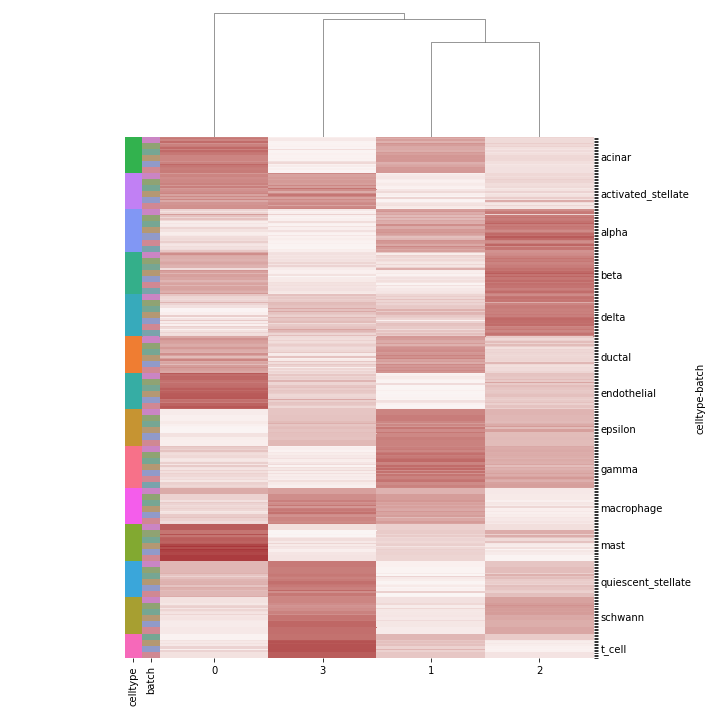

In [50]:
fig= sns.clustermap(df, row_cluster=False, center=0, cmap='vlag', 
                    row_colors=row_cols, cbar_pos= None, 
                    yticklabels=lbl_ticks)
fig.savefig('../rep/fig1_expected_meas.jpg')

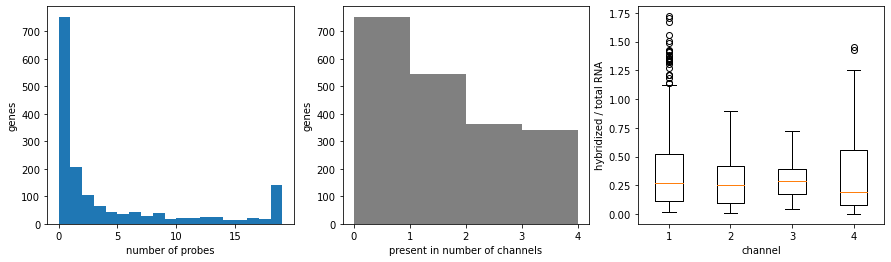

In [59]:
with torch.no_grad():
    pars= mdl.guide(mdl.dat_samp)

fig, axs= plt.subplots(ncols=3, figsize=(15,4))
axs[0].hist(mdl.enc.eval().get_probes().sum(1).tolist(), range(20))
axs[0].set_xlabel('number of probes')
axs[0].set_ylabel('genes')

axs[1].hist((mdl.enc.eval().get_probes()>0).sum(1).tolist(), range(mdl.n_prj+1), color='gray')
axs[1].set_xlabel('present in number of channels')
axs[1].set_ylabel('genes')

axs[2].boxplot((mdl.guide(mdl.dat_samp)['prj']/mdl.dat_samp['cts'].sum(1).unsqueeze(-1)).t().tolist())
axs[2].set_xlabel('channel')
axs[2].set_ylabel('hybridized / total RNA')

fig.savefig('../rep/fig1_allocation_metrics.jpg')

In [54]:
ref_q= sc.read_h5ad('../data/scRNAseq-expts/panc_query.h5ad')
scvi.data.setup_anndata(ref_q, 
                        batch_key='tech', 
                        labels_key='celltype')
(mdl.get_assignment({'cts': torch.FloatTensor(ref_q.X), 'lbl': None})==torch.tensor(ref_q.obs._scvi_labels)).float().mean()

INFO     Using batches from adata.obs["tech"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 4679 cells, 2000 vars, 2 batches, 
         13 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


/Users/igor/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


tensor(0.9404)

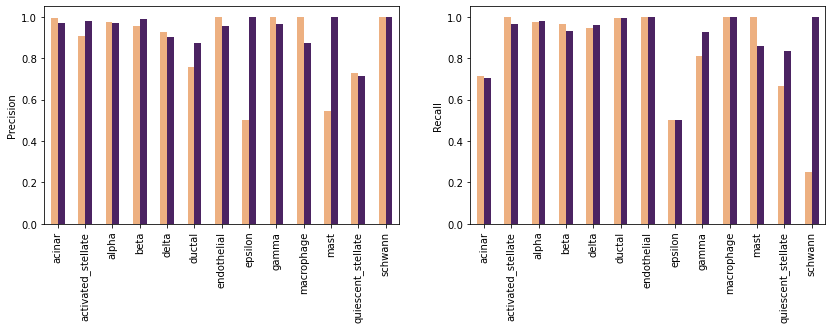

In [55]:
fig, axs= plt.subplots(ncols=2, figsize= (14,4))
ref_q.obs['pred']= [lbl_str[l] for l in mdl.get_assignment({'cts': torch.FloatTensor(ref_q.X), 'lbl': None}).tolist()]
ref_q.obs['mtch']= (ref_q.obs['pred']==ref_q.obs['celltype'])
ref_q.obs.groupby(['pred','_scvi_batch']).mtch.mean().reset_index().rename({'pred':'Assigned Cell', 'mtch': 'Precision'}, axis=1).pivot('Assigned Cell', '_scvi_batch', 'Precision').plot(kind='bar', legend= False, colormap='flare', ax= axs[0])
axs[0].set_ylabel('Precision')
axs[0].set_xlabel('')
ref_q.obs.groupby(['celltype','_scvi_batch']).mtch.mean().reset_index().rename({'mtch': 'Recall', 'celltype':'Reference Type'}, axis=1).pivot('Reference Type', '_scvi_batch', 'Recall').plot(kind='bar', legend= False, colormap='flare', ax= axs[1])
axs[1].set_ylabel('Recall')
axs[1].set_xlabel('')

fig.savefig('../rep/fig1_valid_batch_metrics.jpg')

In [ ]:
ref_a= sc.read_h5ad('../data/scRNAseq-expts/panc_ref.h5ad')
scvi.data.setup_anndata(ref_a, 
                        batch_key='tech', 
                        labels_key='celltype')
ref_q= sc.read_h5ad('../data/scRNAseq-expts/panc_query.h5ad')
scvi.data.setup_anndata(ref_q, 
                        batch_key='tech', 
                        labels_key='celltype')
test_dat= {'cts': torch.FloatTensor(ref_q.X), 'lbl': None}
lbl_str= {s:l for (s,l),_ in ref_a.obs.groupby(['_scvi_labels', 'celltype'])}


In [32]:
from copy import deepcopy as copy
pars= {}
res= []
for prj_loc in (3e2,1e3,3e3,1e4,1.299e4):
    key= prj_loc

#     mdl= VAE3(ref_a, '../data/goterms/human_go.csv', 
#               n_prj=4, probes_per_gene= 20, total_probes=2e4, lblwt=.5, 
#               prj_loc= prj_loc, prj_beta= None, prj_beta_prior= 1)
    mdl= VAELinear(ref_a, n_prj=4, probes_per_gene= 20, total_probes=2e4, lblwt=1, 
                loc_m= prj_loc, beta_m=1, beta_p= None)
    mdl.train(n_iter= 1000, n_btch=4, verbose=False)

    pars[key]= {'dir_loc': copy(pyro.param('dir_loc').detach()), 
                'prj_beta_loc': copy(pyro.param('prj_beta_loc').detach()), 
                'enc_state_dict': mdl.enc.state_dict()}

    ref_q.obs['pred']= [lbl_str[l] for l in mdl.get_assignment(test_dat).tolist()]
    ref_q.obs['mtch']= (ref_q.obs['pred']==ref_q.obs['celltype'])
    ref_q.obs.groupby('pred').mtch.mean().reset_index()
    prec= ref_q.obs.groupby('pred').mtch.mean()
    prec.index= ['prc_%s'%i for i in prec.index]
    recl= ref_q.obs.groupby('celltype').mtch.mean()
    recl.index= ['rcl_%s'%i for i in recl.index]

    test_prj= mdl.guide(test_dat)['prj']
    sgnl= pd.Series([test_prj.mean().item(), test_prj.var().item()], 
                    index=['prj_mean', 'prj_var'])
    key= pd.Series(key, index=['prj_loc'])
    res.append(pd.concat([key, sgnl, prec, recl]))

res_tab= pd.concat(res,1).T

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
prj_full= []
for prj_loc,d in tqdm(pars.items()):
    with torch.no_grad():
        prj= NAPSets(d['enc_state_dict']['prp'].shape[0], 4, 20, 20000)
        prj.load_state_dict(d['enc_state_dict'])
        enc= prj(test_dat['cts'])
        ttl= test_dat['cts'].sum(1)
        loc_res= pd.DataFrame(torch.cat([torch.stack([torch.tensor([prj_loc]*len(ttl)), torch.arange(len(ttl)).long(), ttl, torch.tensor([i]*len(ttl)), enc[:,i]],1) for i in range(enc.shape[1])]).numpy(), columns=['loc','ind','ttl','chnl','obs'])
        prj_full.append(loc_res)

prj_full= pd.concat(prj_full)

  0%|          | 0/5 [00:00<?, ?it/s]

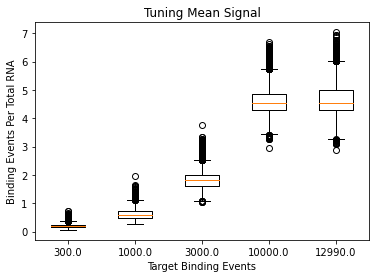

In [35]:
prj_full['nrm_cts']= prj_full['obs']/prj_full['ttl']
grps= dict(list(prj_full.groupby('loc').nrm_cts))
fig, axs= plt.subplots()
_= axs.boxplot(grps.values(), labels=list(grps.keys()))
axs.set_xlabel('Target Binding Events')
axs.set_ylabel('Binding Events Per Total RNA')
axs.set_title('Tuning Mean Signal')
fig.savefig('../rep/fig2_tuning_signal.jpg')

In [36]:
from copy import deepcopy as copy
pars2= {}
res2= []
for prj_beta in 1,.3,.1,.03,.01,.003:
    key= prj_beta

#     mdl= VAE3(ref_a, '../data/goterms/human_go.csv', 
#               n_prj=4, probes_per_gene= 20, total_probes=2e4, lblwt=.5, 
#               prj_loc= 2000, prj_beta= prj_beta, prj_beta_prior= 1)
    mdl= VAELinear(ref_a, n_prj=4, probes_per_gene= 20, total_probes=2e4, lblwt=1, 
                loc_m= 2000, beta_m= 1, beta_p= prj_beta)
    mdl.train(n_iter= 1000, n_btch=4, verbose=False)

    pars2[key]= {'dir_loc': copy(pyro.param('dir_loc').detach()), 
                'enc_state_dict': mdl.enc.state_dict()}

    ref_q.obs['pred']= [lbl_str[l] for l in mdl.get_assignment(test_dat).tolist()]
    ref_q.obs['mtch']= (ref_q.obs['pred']==ref_q.obs['celltype'])
    ref_q.obs.groupby('pred').mtch.mean().reset_index()
    prec= ref_q.obs.groupby('pred').mtch.mean()
    prec.index= ['prc_%s'%i for i in prec.index]
    recl= ref_q.obs.groupby('celltype').mtch.mean()
    recl.index= ['rcl_%s'%i for i in recl.index]

    test_prj= mdl.guide(test_dat)['prj']
    sgnl= pd.Series([test_prj.mean().item(), test_prj.var().item()], 
                    index=['prj_mean', 'prj_var'])
    key= pd.Series(key, index=['prj_beta'])
    res2.append(pd.concat([key, sgnl, prec, recl]))

res_tab2= pd.concat(res2,1).T

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/igor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/igor/opt/anaconda3/lib/python3.8/site-packages/pyro/util.py:286: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta', 'mean'}
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [37]:
prj_full2= []
for prj_beta_prior,d in tqdm(pars2.items()):
    with torch.no_grad():
        prj= NAPSets(d['enc_state_dict']['prp'].shape[0], 4, 20, 20000)
        prj.load_state_dict(d['enc_state_dict'])
        enc= prj(test_dat['cts'])
        ttl= test_dat['cts'].sum(1)
        beta_res= pd.DataFrame(torch.cat([torch.stack([torch.tensor([prj_beta_prior]*len(ttl)), torch.arange(len(ttl)).long(), ttl, torch.tensor([i]*len(ttl)), enc[:,i]],1) for i in range(enc.shape[1])]).numpy(), columns=['beta','ind','ttl','chnl','obs'])
        prj_full2.append(beta_res)

prj_full2= pd.concat(prj_full2)

  0%|          | 0/6 [00:00<?, ?it/s]

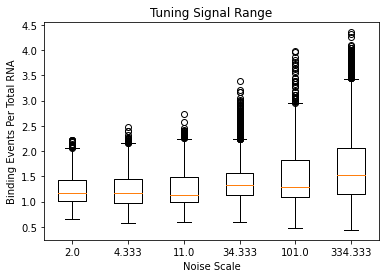

In [39]:
prj_full2['nrm_cts']= prj_full2['obs']/prj_full2['ttl']
prj_full2['var_scl']= [round(i*1000)/1000. for i in (1+1./prj_full2['beta'].values)]
grps= dict(list(prj_full2.groupby('var_scl').nrm_cts))
fig, axs= plt.subplots()
_= axs.boxplot(grps.values(), labels=list(grps.keys()))
axs.set_xlabel('Noise Scale')
axs.set_ylabel('Binding Events Per Total RNA')
axs.set_title('Tuning Signal Range')
fig.savefig('../rep/fig2_tuning_range.jpg')

In [40]:
# mdl_= VAE3(ref_a, '../data/goterms/human_go.csv', 
#            n_prj=4, probes_per_gene= 20, total_probes=2e4, lblwt=.5, 
#            prj_loc= 2000, prj_beta= 1, prj_beta_prior= 1)
mdl_= VAELinear(ref_a, n_prj=4, probes_per_gene= 20, total_probes=2e4, lblwt=1, 
           loc_m= 2000, beta_m= 1, beta_p= 1)
mdl_.train(n_iter= 1000, n_btch=4)


  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/igor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/igor/opt/anaconda3/lib/python3.8/site-packages/pyro/util.py:286: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta', 'mean'}
  warnings.warn(


0 | elbo: 9.61E+05 | prc: 0.07 | r2: 0.01
100 | elbo: 7.04E+05 | prc: 0.38 | r2: 0.32
200 | elbo: 7.22E+05 | prc: 0.62 | r2: 0.40
300 | elbo: 6.57E+05 | prc: 0.82 | r2: 0.42
400 | elbo: 6.31E+05 | prc: 0.92 | r2: 0.42
500 | elbo: 6.15E+05 | prc: 0.97 | r2: 0.43
600 | elbo: 5.93E+05 | prc: 0.99 | r2: 0.43
700 | elbo: 5.84E+05 | prc: 0.96 | r2: 0.43
800 | elbo: 5.74E+05 | prc: 0.98 | r2: 0.43
900 | elbo: 5.67E+05 | prc: 0.98 | r2: 0.43


In [41]:
res2_= []
for prj_beta in 1,.3,.1,.03,.01,.003:
    mdl_.beta_p= prj_beta
    
    ref_q.obs['pred']= [lbl_str[l] for l in mdl_.get_assignment(test_dat).tolist()]
    ref_q.obs['mtch']= (ref_q.obs['pred']==ref_q.obs['celltype'])
    ref_q.obs.groupby('pred').mtch.mean().reset_index()
    prec= ref_q.obs.groupby('pred').mtch.mean()
    prec.index= ['prc_%s'%i for i in prec.index]
    recl= ref_q.obs.groupby('celltype').mtch.mean()
    recl.index= ['rcl_%s'%i for i in recl.index]
    
    key= pd.Series(prj_beta, index=['prj_beta'])
    res2_.append(pd.concat([key, prec, recl]))

res_tab2_= pd.concat(res2_,1).T

In [42]:
tund= pd.concat([res_tab2.set_index('prj_beta')[[i for i in res_tab2.columns if i.startswith('prc_')]].mean(1),
                 res_tab2.set_index('prj_beta')[[i for i in res_tab2.columns if i.startswith('rcl_')]].mean(1)],1)
tund['condition']= 'Train'

bsln= pd.concat([res_tab2_.set_index('prj_beta')[[i for i in res_tab2_.columns if i.startswith('prc_')]].mean(1),
                 res_tab2_.set_index('prj_beta')[[i for i in res_tab2_.columns if i.startswith('rcl_')]].mean(1)],1)
bsln['condition']= 'Post'

comp= pd.concat([tund,bsln]).rename({0:'precision',1:'recall'}, axis=1).set_index('condition', append=True).sort_index()


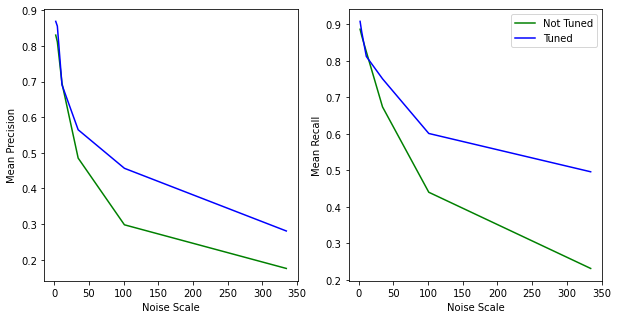

In [44]:
fig, axs= plt.subplots(ncols=2, figsize=(10,5))
for g,v in comp.reset_index().groupby('condition'):
    axs[0].plot((1+1./v.prj_beta), v.precision, 
                label='Not Tuned' if g=='Post' else 'Tuned', 
                c='green' if g=='Post' else 'blue')
    axs[1].plot((1+1./v.prj_beta), v.recall, 
                label='Not Tuned' if g=='Post' else 'Tuned', 
                c='green' if g=='Post' else 'blue')
axs[1].legend()
axs[0].set_ylabel('Mean Precision')
axs[1].set_ylabel('Mean Recall')
axs[0].set_xlabel('Noise Scale')
axs[1].set_xlabel('Noise Scale')
fig.savefig('../rep/fig2_perf_deg.jpg')